# 差异可及峰

我们可以比较在不同分组中表现出差异可及性的染色质峰，并鉴定其中保守的基序

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import exprmat as em

em.setwd('/home/data/yangz/shared/tutorial/bulk-atac')
ver = em.version()

[i] exprmat 0.1.48 / exprmat-db 0.1.48
[i] os: posix (linux)  platform version: 5.15.0-139-generic
[i] loaded configuration from /home/data/yangz/.exprmatrc
[i] current working directory: /home/data/yangz/shared/tutorial/bulk-atac
[i] current database directory: /home/data/yangz/bioinfo/packages/database (0.1.48)
[i] resident memory: 810.28 MiB
[i] virtual memory: 5.78 GiB


In [ ]:
expm = em.load_experiment('bk-atac')

In [5]:
expm['atac']['bulk-atac'].obs

,n.fragments,pct.dup,pct.mito,location,sample,batch,group,modality,taxa,tsse
bulk-atac:c1,25596750,0.000264,0.0,src/control-1.bam,c1,b-1,control,atac-bulk,hsa/grch38,7.181466
bulk-atac:c2,29933508,0.000356,0.0,src/control-2.bam,c2,b-1,control,atac-bulk,hsa/grch38,4.210467
bulk-atac:c3,26024477,0.000272,0.0,src/control-3.bam,c3,b-1,control,atac-bulk,hsa/grch38,7.388964
bulk-atac:e1,24406481,0.000328,0.0,src/hp-1.bam,e1,b-1,expm,atac-bulk,hsa/grch38,9.118949
bulk-atac:e2,26010889,0.000294,0.0,src/hp-2.bam,e2,b-1,expm,atac-bulk,hsa/grch38,7.051591
bulk-atac:e3,23710917,0.000301,0.0,src/hp-3.bam,e3,b-1,expm,atac-bulk,hsa/grch38,8.239926


In [6]:
print(expm)

[!] dataset not integrated.
[*] composed of samples:
  bulk-atac   atac   hsa    batch autogen   of size 6 × 0
  bulk-atac   atac-p hsa    batch autogen   of size 6 × 48519



### 将峰注释到基因

分析 ATAC-seq 数据常常用距离一个启动子的远近作为这个可及峰的相关基因的假设

In [7]:
expm.run_atacp_annotate_peak(run_on_samples = ['bulk-atac'])

In [8]:
expm['atac-p']['bulk-atac'].var[['type', 'tss.nearest', 'ugene', 'gene', 'tss.dist']]

,type,tss.nearest,ugene,gene,tss.dist
peak:grch38:chr1:9853-10354,promoter,ENSG00000290825,rna:hsa:g1,DDX11L16,-1016.0
peak:grch38:chr1:15983-16484,promoter,ENSG00000310526,rna:hsa:g2,WASH7P,-865.0
peak:grch38:chr1:181228-181729,promoter,ENSG00000308415,rna:hsa:g18,DDX11L2,-181.0
peak:grch38:chr1:180549-181050,promoter,ENSG00000308415,rna:hsa:g18,DDX11L2,-130.0
peak:grch38:chr1:191240-191741,first-intron,ENSG00000310527,rna:hsa:g19,WASH9P,1386.0
...,...,...,...,...,...
peak:grch38:chrY:56706793-56707294,intergenic,ENSG00000235857,rna:hsa:g78922,CTBP2P1,-148199.0
peak:grch38:chrY:56727895-56728396,intergenic,ENSG00000235857,rna:hsa:g78922,CTBP2P1,-127097.0
peak:grch38:chrY:56734538-56735039,intergenic,ENSG00000235857,rna:hsa:g78922,CTBP2P1,-120454.0
peak:grch38:chrY:56742463-56742964,intergenic,ENSG00000235857,rna:hsa:g78922,CTBP2P1,-112529.0


### 差异可及峰

使用批量 RNA-seq 数据差异分析常用的 DEseq2 方法被认为可以适用于差异可及峰的统计检验

In [11]:
expm.run_atacp_markers_deseq(
    run_on_samples = ['bulk-atac'], counts = 'X',
    metadata = ['sample', 'group'], formula = '~ group',
    variable = 'group', experiment = 'expm', control = 'control',
)

[i] fitting size factors ...
[i] using None as control genes, passed at deseq_dataset initialization
[i]   done in 0.01 seconds.
[i] fitting dispersions...
[i]   done in 3.90 seconds.
[i] fitting dispersion trend curve ...
[i]   done in 0.85 seconds.
[i] fitting map dispersions ...
[i]   done in 3.85 seconds.
[i] fitting log fold changes ...
[i]   done in 4.48 seconds.
[i] calculating cook's distance ...
[i]   done in 0.02 seconds.
[i] replacing 0 outlier genes.


例如，我们筛选出 TCF7 基因座附近的差异可及峰

In [12]:
upreg = expm.get_atacp_markers(
    ['bulk-atac'], de_slot = 'markers', max_q = 1, 
    min_lfc = 0.1, max_lfc = 10000)['bulk-atac'][
        ['mean', 'lfc', 'lfc.se', 'names', 'gene', 'q']
].sort_values('lfc')

upreg.loc[upreg['gene'] == 'TCF7', :]

[i] fetched diff `expm` over `control` (14047 genes)


,mean,lfc,lfc.se,names,gene,q
37300,29.540347,0.156705,0.336371,peak:grch38:chr5:134113861-134114362,TCF7,0.999857
37302,60.085868,0.259853,0.241759,peak:grch38:chr5:134132392-134132893,TCF7,0.999857
37304,30.137926,0.752380,0.323924,peak:grch38:chr5:134140398-134140899,TCF7,0.999857


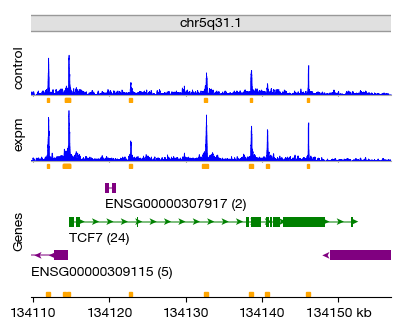

In [13]:
figs = expm.plot_atac_peaks(
    run_on_samples = ['bulk-atac'], group_key = 'group', peaks_key = 'peaks.group',
    # either specifying a gene name for convenience
    gene = 'TCF7', upstream = 5000, downstream = 5000, 
    # or specify chromosome coordinates manually
    chr = None, xf = None, xt = None, 
    figsize = (4, 3.2), dpi = 100, 
    gene_track_height = 0.45, chrom_track_height = 0.10,  
    peak_annotation_height = 0.1,
    min_frag_length = None, max_frag_length = 180,
    plot_consensus_peak = 'peaks.merged',
    title = None, showgn = True
)

### 提取峰对应序列

为了分析峰中富集的基序，我们需要从参考基因组中提取峰对应的序列

In [14]:
expm.run_atacp_retrieve_sequence(['bulk-atac'], seqlen = 200)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━ fetching chromosome     24 / 24    (00:20 < 00:00)


In [15]:
expm['atac-p']['bulk-atac'].var[['strand.pos']]

,strand.pos
peak:grch38:chr1:9853-10354,ACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCC...
peak:grch38:chr1:15983-16484,CCTGAGCGCGGGCATCCTGTGTGCAGATACTCCCTGCTTCCTCTCT...
peak:grch38:chr1:181228-181729,GGCGCAGAGACACATGCTAGCGCGCCCAGGGGAGGAGGCGTGGCGC...
peak:grch38:chr1:180549-181050,CCTAACCCTAACCCTACCCTAACCCAACCCTAACCCAACCCTAACT...
peak:grch38:chr1:191240-191741,TGACTGTCATCCCCTCCAGTCTCTGCACACTCCCAGCTGCAGCAGA...
...,...
peak:grch38:chrY:56706793-56707294,GGAATGGAGTGCAGTGCAATGGAATGGAATGGAATGGAATGCAATG...
peak:grch38:chrY:56727895-56728396,ATGGAATGGAATCGAATGCAATGGAATGCTATGGAATGGAATGGAA...
peak:grch38:chrY:56734538-56735039,AAAGGAATCGAATGGAAGGGAATGAAATTGAATCAACACGAATGGA...
peak:grch38:chrY:56742463-56742964,AATGTAATGGAATGGAGTGCAGTGCAATGGAATGGAATGGAATGGA...


将差异可及峰比对到过度表示的基序

In [16]:
expm.run_atacp_motif_match(
    run_on_samples = ['bulk-atac'],
    motif_matches = 'motifs',
    subset = 'jaspar',
    length = 200,
    threshold = 0.00001
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━ generating pssm      10249 / 10249 (00:00 < 00:00)


[i] matching motifs for foreground ...


   ━━━━━━━━━━━━━━━━━━━━━━━━━━ foreground matching   1936 / 1936  (02:44 < 00:00)


接下来进行统计检验

In [17]:
expm.run_atacp_motif_enrichment(
    run_on_samples = ['bulk-atac'],
    background = 'background',
    n = 5000,
    length = 200,
    random_seed = 42,
    threshold = 0.00001,
    motif_matches = 'motifs',
    key_added = 'motifs.enrich',
    subset = 'jaspar'
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━ generating pssm      10249 / 10249 (00:00 < 00:00)


[i] generating background regions ...
[i] fetching chromosomes, round 1 ...
[i] fetching chromosomes, round 2 ...
[i] fetching chromosomes, round 3 ...
[i] fetching chromosomes, round 4 ...
[i] fetching chromosomes, round 5 ...
[i] fetching chromosomes, round 6 ...
[i] fetching chromosomes, round 7 ...
[i] fetching chromosomes, round 8 ...
[i] fetching chromosomes, round 9 ...
[i] fetching chromosomes, round 10 ...
[i] fetching chromosomes, round 11 ...
[i] matching motifs for background ...


   ━━━━━━━━━━━━━━━━━━━━━━━━━━ background matching   1936 / 1936  (00:05 < 00:00)


我们可以查看结果表，按照统计检验有效性排列

In [18]:
m = expm['atac-p']['bulk-atac'].uns['motifs.enrich'].copy()
m.loc[~m['chisq'].isna(), :].sort_values('chisq', ascending = False)

,motif,fg.hit,fg,gc,bg.hit,bg,fg.ratio,bg.ratio,fc,chisq,p,log10.p
1255,motif:18810,934,48519,0.560541,529,5000,0.019250,0.1058,0.181949,1.277047e+03,0.000000,inf
731,motif:18013,7062,48519,0.580299,31,5000,0.145551,0.0062,23.476004,7.656322e+02,0.000000,inf
1150,motif:18349,229,48519,0.520852,194,5000,0.004720,0.0388,0.121644,6.714164e+02,0.000000,inf
1175,motif:18478,200,48519,0.507400,144,5000,0.004122,0.0288,0.143128,4.322554e+02,0.000000,inf
734,motif:19009,4501,48519,0.594672,42,5000,0.092768,0.0084,11.043784,4.153527e+02,0.000000,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
1501,motif:36464,78,48519,0.457179,8,5000,0.001608,0.0016,1.004761,1.639540e-04,0.989784,0.004460
536,motif:18443,116,48519,0.634914,12,5000,0.002391,0.0024,0.996173,1.602428e-04,0.989900,0.004409
554,motif:18530,39,48519,0.483974,4,5000,0.000804,0.0008,1.004761,8.191109e-05,0.992779,0.003147
388,motif:18578,184,48519,0.489103,19,5000,0.003792,0.0038,0.997981,7.059359e-05,0.993296,0.002921


### 基序可视化

表中的基序代码是 exprmat 数据库中对真核生物基序的编码，我们可以通过代码查询可视化基序

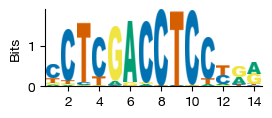

In [19]:
from exprmat.data.cre import plot_sequence_logo, search_transcription_factor

mot = plot_sequence_logo('motif:18810')

我们也可以根据注释的转录因子查询其结合的基序列表

In [20]:
search_transcription_factor('hsa', 'TCF7', 'jaspar')

[('mc:311', 'motif:18190'),
 ('mc:311', 'motif:18688'),
 ('mc:311', 'motif:19071'),
 ('mc:4295', 'motif:18389'),
 ('mc:119', 'motif:18944'),
 ('mc:119', 'motif:18945'),
 ('mc:119', 'motif:18948'),
 ('mc:119', 'motif:18952'),
 ('mc:119', 'motif:18953'),
 ('mc:9071', 'motif:18390')]

### 基序的转录因子足迹

基序的转录因子结合区因为蛋白质的保护作用会产生足迹效应

In [21]:
expm.run_atacp_footprint(
    ['bulk-atac'],
    atac = 'bulk-atac',
    motif = 'motif:18944',
    motif_matches = 'motifs',
    groupby = 'group',
    key_added = 'footprint.tcf7-1'
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━ summarizing peaks     1075 / 1075  (01:57 < 00:00)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━ summarizing peaks     1075 / 1075  (02:08 < 00:00)


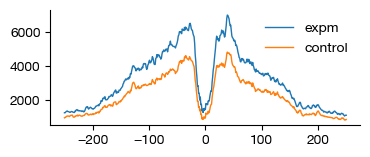

In [23]:
from exprmat.plotting.utils import line

fig = line(
    x = [x - 250 for x in range(501)],
    y = expm['atac-p']['bulk-atac'].uns['footprint.tcf7-1'],
    figsize = (4, 1.5),
)

### ChromVAR 实现

对于每个样本，我们可以统计一个基序的结合变异程度并得到变异矩阵，得到在不同样本中有变异的基序矩阵

In [24]:
chromvar = expm.run_atacp_chromvar(
    ['bulk-atac'],
    chunk_size = 10000,
    background = 'bg.intern',
    motif_matches = 'motifs',
    gc_key = 'gc', subset = 'jaspar',
    length = 200, threshold = 1e-5
)

[!] cannot find background peaks in the input object .varm
[!] calculating internal background peaks and inserting to .varm['bg.intern']
[i] computing expectation reads per cell and peak ...
[i] computing observed + bg motif deviations...
[i] calculating for rows (cells) 0 - 6 ...


   ━━━━━━━━━━━━━━━━━━━━━━━━━ background iterations    50 / 50    (00:07 < 00:00)


In [25]:
print(expm)

[!] dataset not integrated.
[*] composed of samples:
  bulk-atac   atac          hsa    batch autogen   of size 6 × 0
  bulk-atac   atac-p        hsa    batch autogen   of size 6 × 48519
  bulk-atac   atac-chromvar hsa    batch autogen   of size 6 × 1936



In [29]:
em.pd.DataFrame(
    expm['atac-chromvar']['bulk-atac'].X,
    index = expm['atac-chromvar']['bulk-atac'].obs_names,
    columns = expm['atac-chromvar']['bulk-atac'].var_names
).iloc[:, 0:6]

,motif:18200,motif:17986,motif:17990,motif:17992,motif:18399,motif:18983
bulk-atac:c1,-1.715671,1.849657,1.455513,1.831647,1.065492,1.441480
bulk-atac:c2,0.003073,-0.969662,-0.461601,-0.940206,-0.562150,-0.533376
bulk-atac:c3,-1.448396,3.508345,0.699794,3.322296,1.392191,1.790036
bulk-atac:e1,0.885136,-1.268004,-0.321142,-1.894677,-0.303776,-1.591238
bulk-atac:e2,1.420448,-3.043641,-1.137865,-2.807431,-1.212565,-0.457472
bulk-atac:e3,0.062925,1.518287,0.627722,2.024162,0.460492,0.830303


### 保存数据集

现在保存我们做出的更改

In [30]:
expm.save()

[i] saving individual samples. (pass `save_samples = False` to skip)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━ modality [atac]          1 / 1     (00:03 < 00:00)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━ modality [atac-p]        1 / 1     (00:00 < 00:00)
   ━━━━━━━━━━━━━━━━━━━━━━ modality [atac-chromvar]     1 / 1     (00:00 < 00:00)
